In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import mcu
import swiss_roll_dataset_generator as roll_gen
import dataset_generator


/Users/Ekaterina.Inkina/Library/Python/3.9/lib/python/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


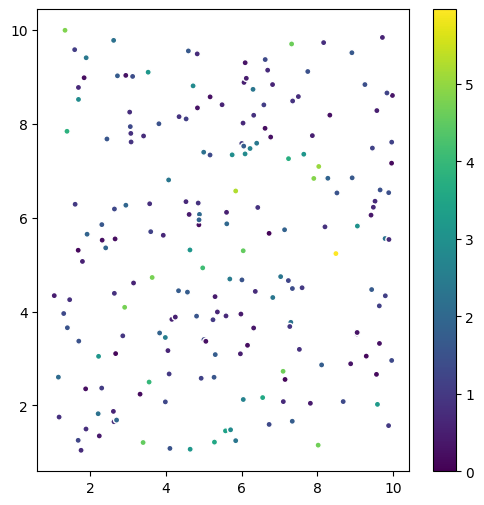

0.1426801493748149


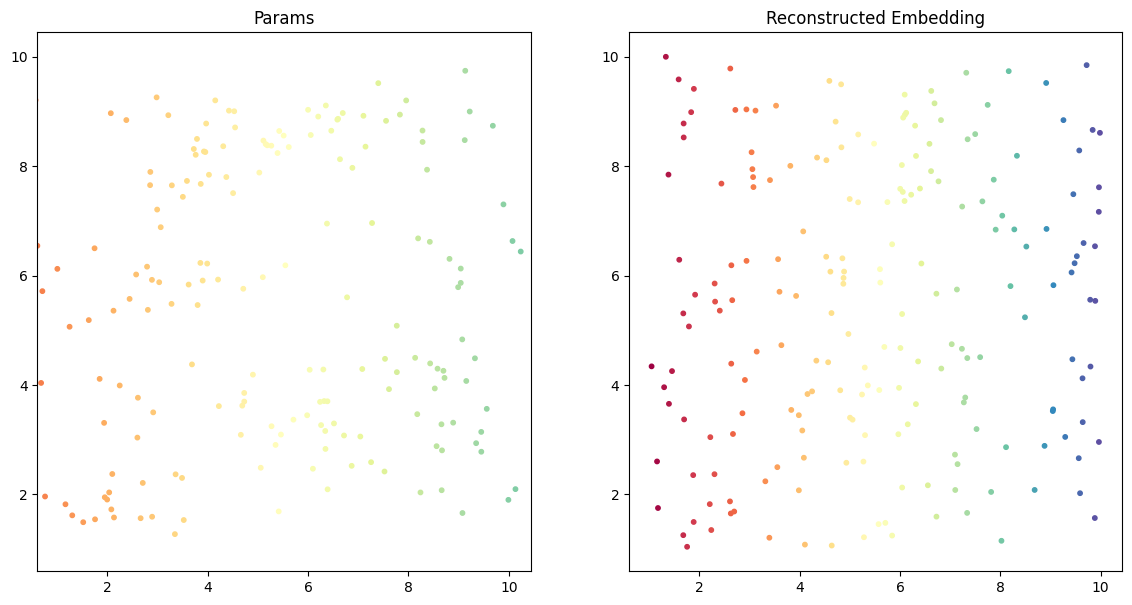

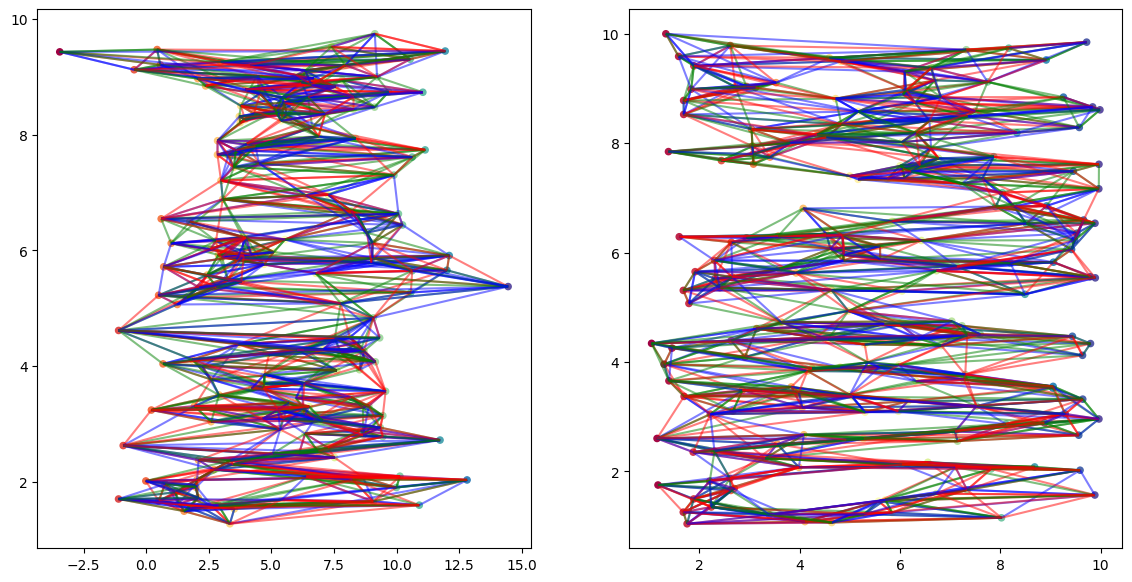

In [3]:
figure_num = 200
figure_point_cnt = 1600
deterministic_param_scatter = False
p = 2
noise_level=0
lw = [1, 1]
up = [10, 10]
control_vars = dataset_generator.get_control_vars(deterministic=deterministic_param_scatter, dimensionality=p,
                                                  size=figure_num,
                                                  lw=lw, up=up)
# control_vars = np.array([[1, 1], [1, 1],[1, 1], [1, 1], [1, 1],[1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]])
rolls = roll_gen.generate_array_of_swiss_rolls(control_vars, noise_level=noise_level, min_num_points=figure_point_cnt)
k = 6
c = 1e5
standardized_x, centered_y, edges, y_means, y_scaler, x_means, x_stds = mcu.prepare_data(control_vars, rolls, k)

q = mcu.solve_semidefinite_programming(standardized_x, centered_y, edges, c)

ld_embedding = mcu.reduce_dimensions(q, 2)
regression_matrix = mcu.regress(ld_embedding, standardized_x)
reconstructed_y = np.dot(standardized_x, regression_matrix)

ld_embedding_to_params = np.dot(ld_embedding, np.linalg.inv(regression_matrix)) * x_stds + x_means
reconstructed_y_to_params = standardized_x * x_stds + x_means

rre = mcu.compute_rre(ld_embedding_to_params, reconstructed_y_to_params)
mcu.plot_rre_heatmap(np.linalg.norm(ld_embedding_to_params - reconstructed_y_to_params, axis=1),
                     reconstructed_y_to_params)
print(np.median(rre))
mcu.plot_embeddings_vs_parameters(ld_embedding_to_params, reconstructed_y_to_params)
mcu.plot_graph(edges, ld_embedding_to_params, reconstructed_y_to_params)

In [4]:
pieces_cnt = 12
test_data_size = 50
intervals = [np.linspace(lw[0], up[0], pieces_cnt + 1), np.linspace(lw[1], up[1], pieces_cnt + 1)]
interval_runs = np.empty(shape=(pieces_cnt, pieces_cnt, 3, 2))
for i in range(pieces_cnt):
    for j in range(pieces_cnt):
        interval_lw = [intervals[0][i], intervals[1][j]]
        interval_up = [intervals[0][i + 1], intervals[1][j + 1]]
        test_control_vars = dataset_generator.get_control_vars(deterministic=False, dimensionality=p,
                                                               size=test_data_size, lw=interval_lw, up=interval_up)
        test_rolls = roll_gen.generate_array_of_swiss_rolls(control_vars, noise_level=noise_level, min_num_points=figure_point_cnt)
        x_opts = []
        for (roll, control_var) in zip(test_rolls, test_control_vars):
            x_opt, x_err = mcu.predictive_optimization(roll, centered_y, ld_embedding, regression_matrix, y_means,
                                                       y_scaler, k)
            x_opt = x_opt * x_stds + x_means
            x_opts.append(x_opt)
            print("-----------")
            print(f"x_opt  = {x_opt}, x_err = {x_err}")
            print(f"x_real = {control_var}")
        x_ops = np.array(x_opts)
        test_control_vars = np.array(test_control_vars)
        errors = x_opts - test_control_vars
        errors0 = np.power(errors[:, 0], 2)
        errors1 = np.power(errors[:, 1], 2)
        errors_common = np.linalg.norm(errors, axis=1)
        interval_runs[i, j] = [[np.median(errors0), np.percentile(errors0, 75) - np.percentile(errors0, 25)],
                               [np.median(errors1), np.percentile(errors1, 75) - np.percentile(errors1, 25)],
                               [np.median(errors_common),
                                np.percentile(errors_common, 75) - np.percentile(errors_common, 25)]]
        print(errors0)
        print(errors1)
        print(errors_common)

-----------
x_opt  = [8.71627411 8.68589673], x_err = 53.03173386582061
x_real = [1.71157069 1.74491041]
-----------
x_opt  = [2.20530982 3.21199431], x_err = 147.62816913567187
x_real = [1.2649046 1.362198 ]
-----------
x_opt  = [4.16237935 7.20883405], x_err = 70.13971938628484
x_real = [1.43491658 1.29180472]
-----------
x_opt  = [2.20530982 2.13914934], x_err = 189.76418387288317
x_real = [1.42586309 1.54564533]
-----------
x_opt  = [4.71661877 2.28210417], x_err = 27.2690782908695
x_real = [1.00729188 1.09731158]
-----------
x_opt  = [3.15093845 3.12430205], x_err = 101.66697704687441
x_real = [1.16081807 1.1192056 ]
-----------
x_opt  = [8.82850332 5.56391955], x_err = 482.2979297162002
x_real = [1.31671578 1.73992201]
-----------
x_opt  = [8.82850332 8.78657782], x_err = 216.38768234789677
x_real = [1.01800287 1.70442455]
-----------
x_opt  = [3.9185252  3.67440496], x_err = 45.079374862316
x_real = [1.40858146 1.37821738]
-----------
x_opt  = [5.71335019 2.13914934], x_err = 29

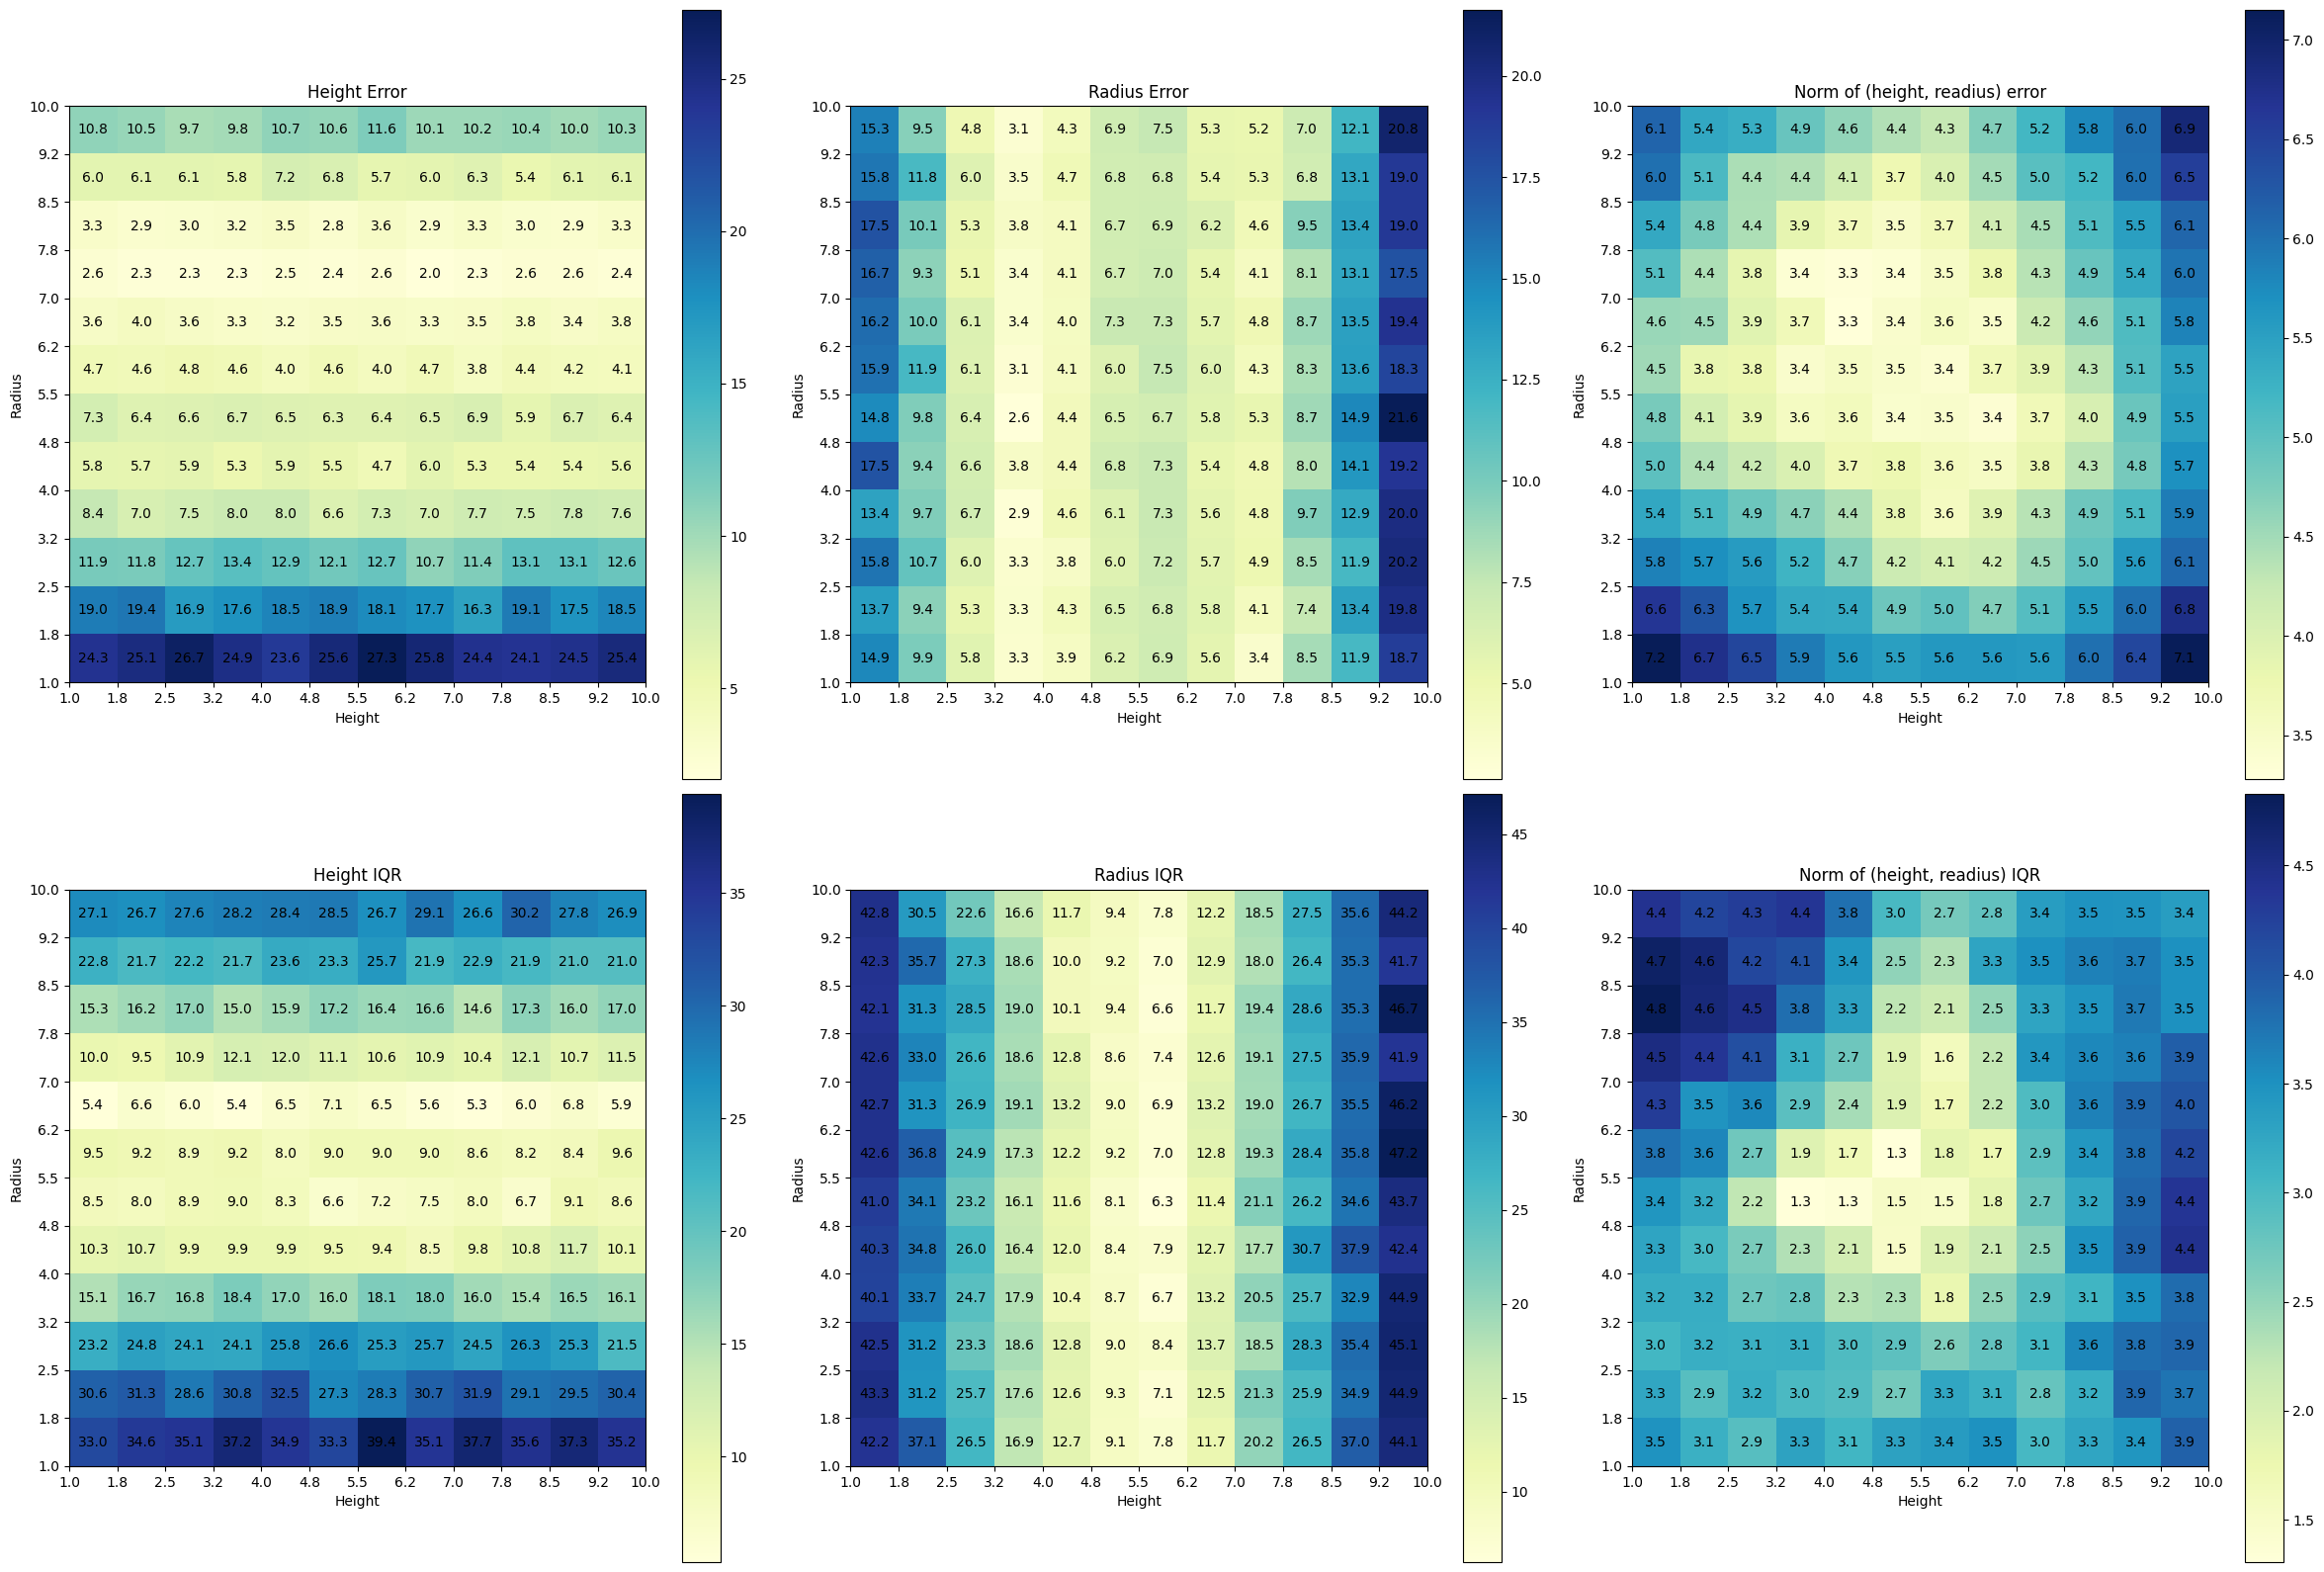

In [5]:
x_values = np.linspace(lw[0], up[0], pieces_cnt + 1)
y_values = np.linspace(lw[1], up[1], pieces_cnt + 1)[::-1]

fig, axs = plt.subplots(2, 3, figsize=(24, 16))

imgs = []
cbars = []

for k in range(3):
    imgs.append(axs[0, k].imshow(interval_runs[:, :, k, 0], cmap='YlGnBu', interpolation='nearest'))
    axs[0, k].set_xlabel('Height')
    axs[0, k].set_ylabel('Radius')
    axs[0, k].set_xticks(np.arange(pieces_cnt + 1) - 0.5, [f'{x:.1f}' for x in x_values])
    axs[0, k].set_yticks(np.arange(pieces_cnt + 1) - 0.5, [f'{y:.1f}' for y in y_values])
    fig.colorbar(imgs[-1], ax=axs[0, k])

    for i in range(pieces_cnt):
        for j in range(pieces_cnt):
            axs[0, k].text(j, i, f'{interval_runs[i, j, k, 0]:.1f}', ha='center', va='center', color='black')

axs[0, 0].set_title('Height Error')
axs[0, 1].set_title('Radius Error')
axs[0, 2].set_title('Norm of (height, readius) error')

for k in range(3):
    imgs.append(axs[1, k].imshow(interval_runs[:, :, k, 1], cmap='YlGnBu', interpolation='nearest'))
    axs[1, k].set_xlabel('Height')
    axs[1, k].set_ylabel('Radius')
    axs[1, k].set_xticks(np.arange(pieces_cnt + 1) - 0.5, [f'{x:.1f}' for x in x_values])
    axs[1, k].set_yticks(np.arange(pieces_cnt + 1) - 0.5, [f'{y:.1f}' for y in y_values])
    fig.colorbar(imgs[-1], ax=axs[1, k])

    for i in range(pieces_cnt):
        for j in range(pieces_cnt):
            axs[1, k].text(j, i, f'{interval_runs[i, j, k, 1]:.1f}', ha='center', va='center', color='black')

axs[1, 0].set_title('Height IQR')
axs[1, 1].set_title('Radius IQR')
axs[1, 2].set_title('Norm of (height, readius) IQR')

plt.tight_layout()
plt.show()

In [6]:
intervals = [np.linspace(lw[0], up[0], pieces_cnt + 1), np.linspace(lw[1], up[1], pieces_cnt + 1)]
interval_runs = np.empty(shape=(pieces_cnt, pieces_cnt, 3, 2))
for i in range(pieces_cnt):
    for j in range(pieces_cnt):
        interval_lw = [intervals[0][i + 1], intervals[1][j + 1]]
        interval_up = [intervals[0][i + 1], intervals[1][j + 1]]
        test_control_vars = dataset_generator.get_control_vars(deterministic=False, dimensionality=p,
                                                               size=test_data_size, lw=interval_lw, up=interval_up)
        test_rolls = roll_gen.generate_array_of_swiss_rolls(control_vars, noise_level=noise_level, min_num_points=figure_point_cnt)
        x_opts = []
        for (roll, control_var) in zip(test_rolls, test_control_vars):
            x_opt, x_err = mcu.predictive_optimization(roll, centered_y, ld_embedding, regression_matrix, y_means,
                                                       y_scaler, k)
            x_opt = x_opt * x_stds + x_means
            x_opts.append(x_opt)
            print("-----------")
            print(f"x_opt  = {x_opt}, x_err = {x_err}")
            print(f"x_real = {control_var}")
        x_ops = np.array(x_opts)
        test_control_vars = np.array(test_control_vars)
        errors = x_opts - test_control_vars
        errors0 = np.power(errors[:, 0], 2)
        errors1 = np.power(errors[:, 1], 2)
        errors_common = np.linalg.norm(errors, axis=1)
        interval_runs[i, j] = [[np.median(errors0), np.percentile(errors0, 75) - np.percentile(errors0, 25)],
                               [np.median(errors1), np.percentile(errors1, 75) - np.percentile(errors1, 25)],
                               [np.median(errors_common),
                                np.percentile(errors_common, 75) - np.percentile(errors_common, 25)]]
        print(errors0)
        print(errors1)
        print(errors_common)

-----------
x_opt  = [8.3419158  8.64986352], x_err = 0.06950725201225105
x_real = [1.75 1.75]
-----------
x_opt  = [2.20530982 3.20189331], x_err = 50.00620454390736
x_real = [1.75 1.75]
-----------
x_opt  = [3.04439962 7.23043381], x_err = 4.8719666660077845
x_real = [1.75 1.75]
-----------
x_opt  = [2.20530982 2.13914934], x_err = 84.76085075364392
x_real = [1.75 1.75]
-----------
x_opt  = [3.5630247  2.26251542], x_err = 12.652857778043863
x_real = [1.75 1.75]
-----------
x_opt  = [4.31479512 3.09460249], x_err = 2.3430925176650663
x_real = [1.75 1.75]
-----------
x_opt  = [8.82850332 5.64825405], x_err = 106.59578329743437
x_real = [1.75 1.75]
-----------
x_opt  = [8.82850332 8.733605  ], x_err = 15.079396056650127
x_real = [1.75 1.75]
-----------
x_opt  = [4.69594349 3.63951448], x_err = 2.392244434042735
x_real = [1.75 1.75]
-----------
x_opt  = [7.76995603 2.13914934], x_err = 1480.680242115679
x_real = [1.75 1.75]
-----------
x_opt  = [6.43538062 3.72605963], x_err = 3.3967666

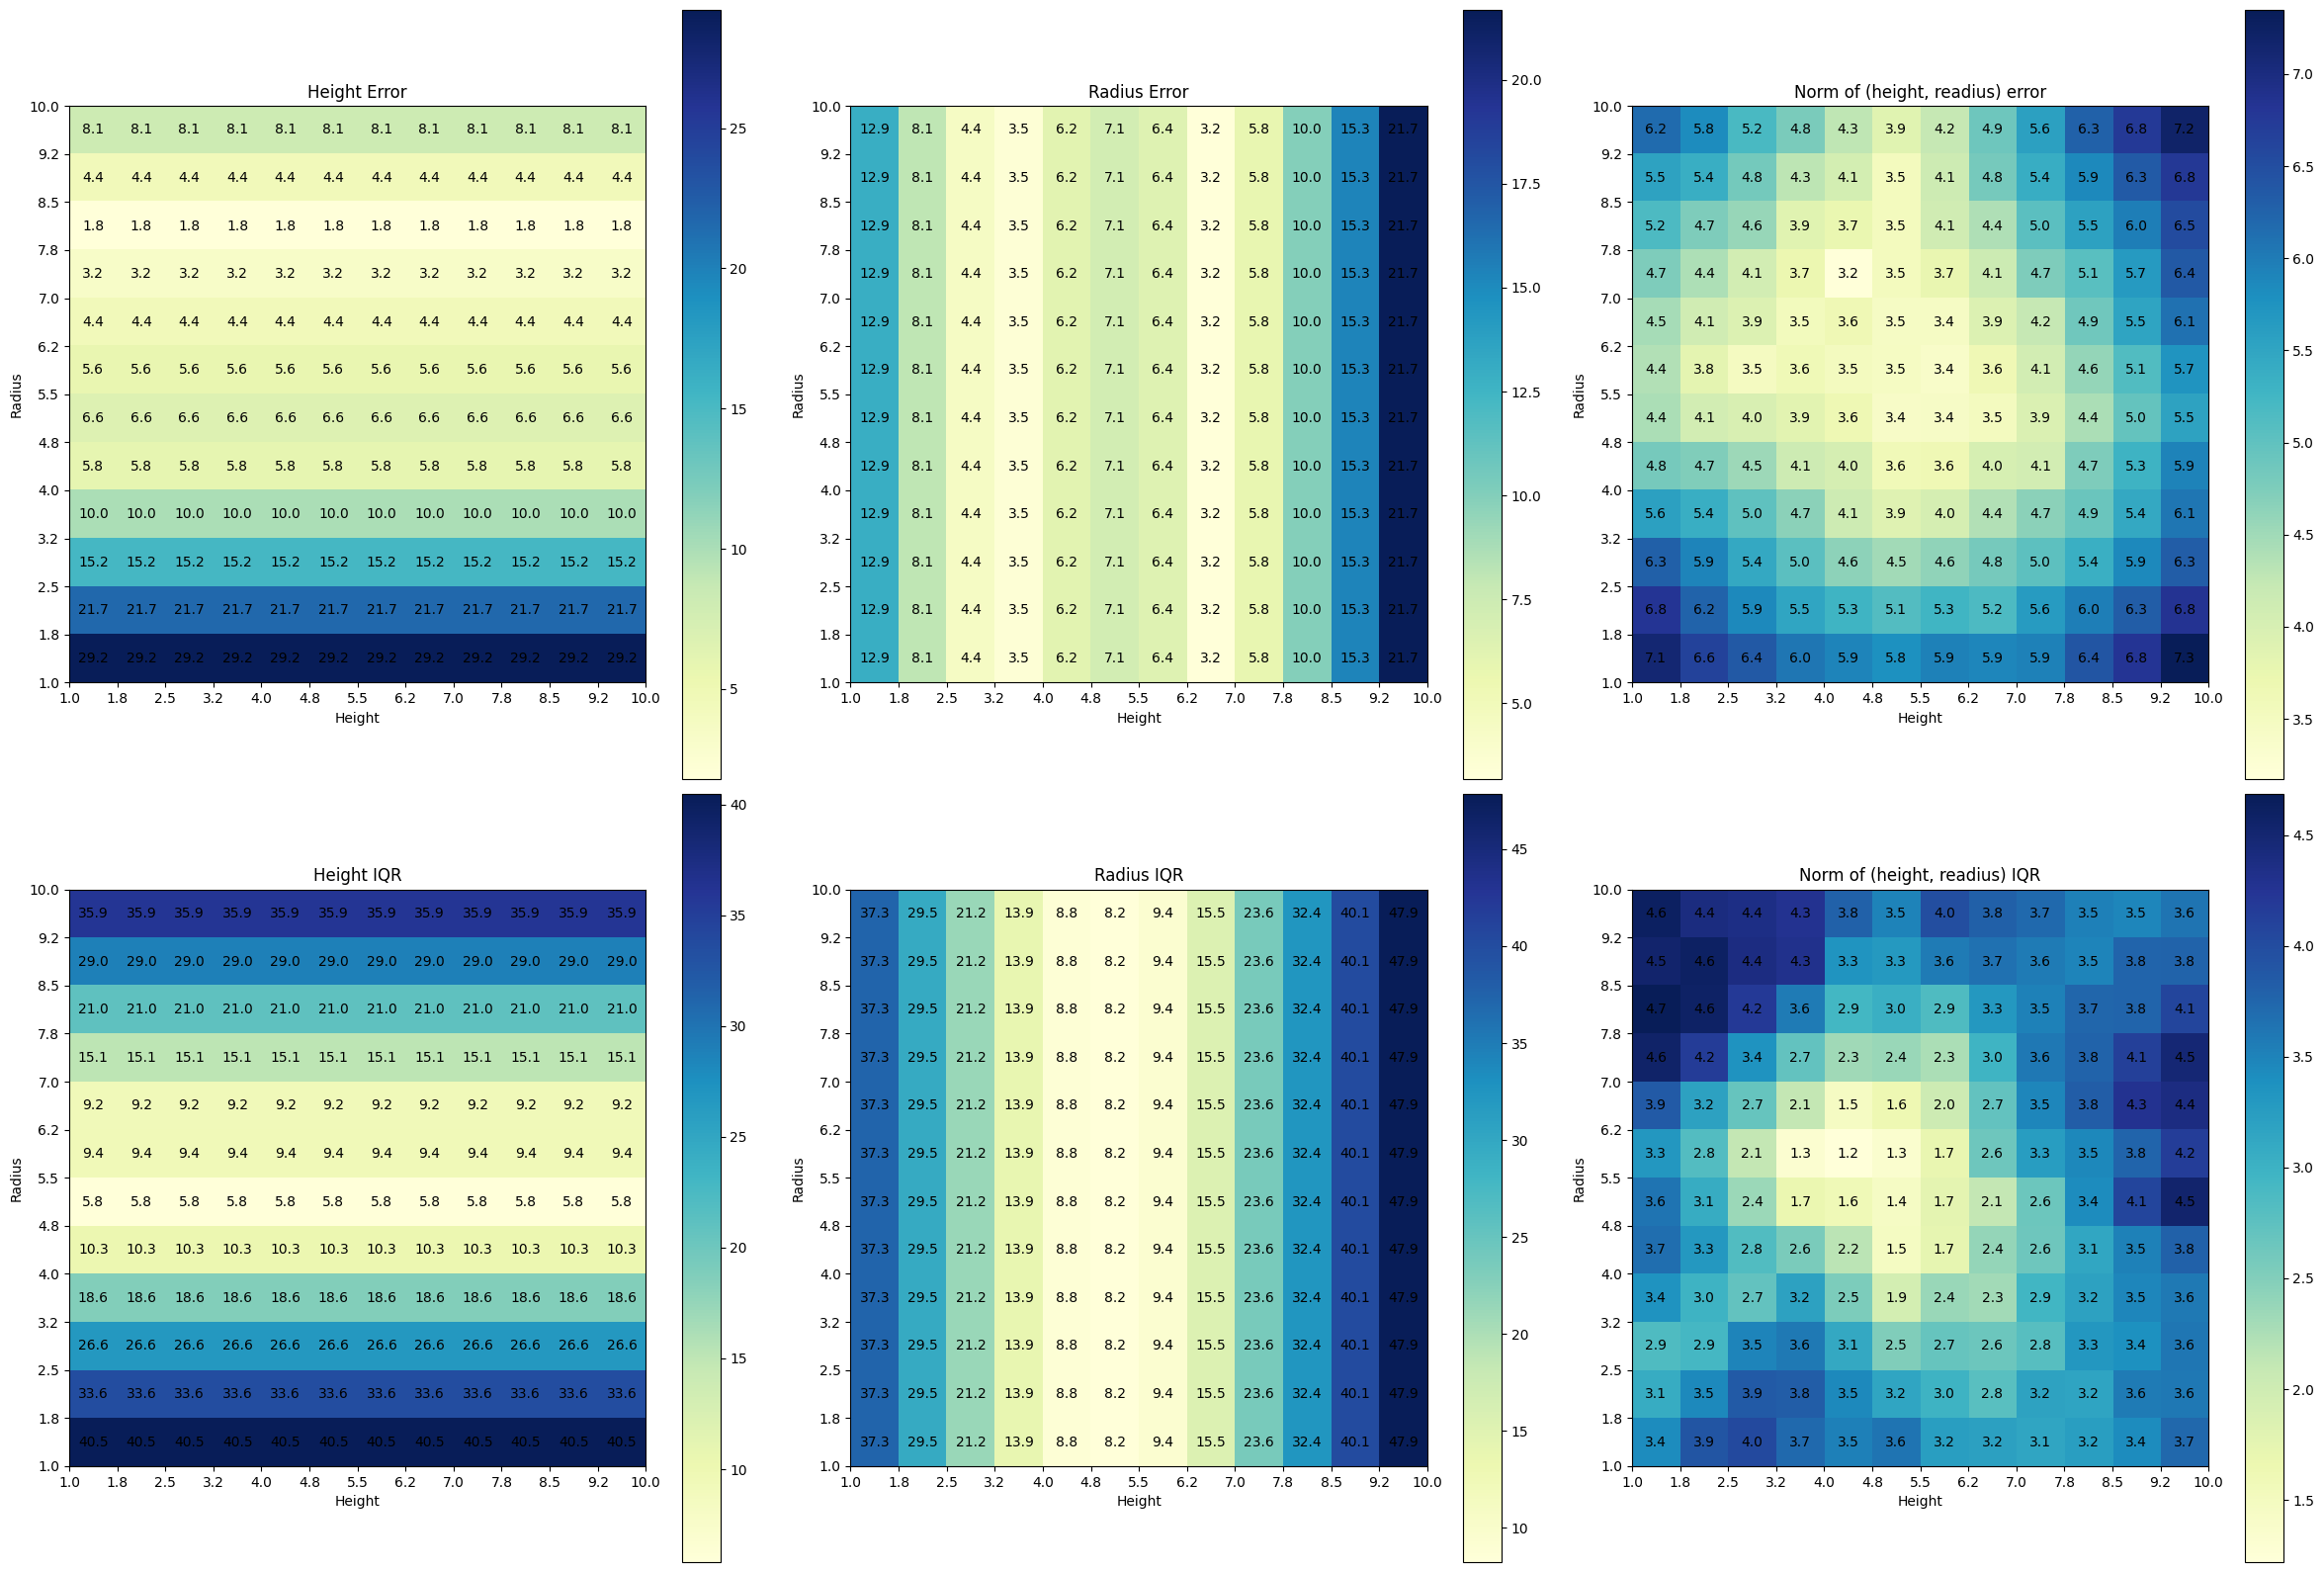

In [7]:
x_values = np.linspace(lw[0], up[0], pieces_cnt + 1)
y_values = np.linspace(lw[1], up[1], pieces_cnt + 1)[::-1]

fig, axs = plt.subplots(2, 3, figsize=(24, 16))

imgs = []
cbars = []

for k in range(3):
    imgs.append(axs[0, k].imshow(interval_runs[:, :, k, 0], cmap='YlGnBu', interpolation='nearest'))
    axs[0, k].set_xlabel('Height')
    axs[0, k].set_ylabel('Radius')
    axs[0, k].set_xticks(np.arange(pieces_cnt + 1) - 0.5, [f'{x:.1f}' for x in x_values])
    axs[0, k].set_yticks(np.arange(pieces_cnt + 1) - 0.5, [f'{y:.1f}' for y in y_values])
    fig.colorbar(imgs[-1], ax=axs[0, k])

    for i in range(pieces_cnt):
        for j in range(pieces_cnt):
            axs[0, k].text(j, i, f'{interval_runs[i, j, k, 0]:.1f}', ha='center', va='center', color='black')

axs[0, 0].set_title('Height Error')
axs[0, 1].set_title('Radius Error')
axs[0, 2].set_title('Norm of (height, readius) error')

for k in range(3):
    imgs.append(axs[1, k].imshow(interval_runs[:, :, k, 1], cmap='YlGnBu', interpolation='nearest'))
    axs[1, k].set_xlabel('Height')
    axs[1, k].set_ylabel('Radius')
    axs[1, k].set_xticks(np.arange(pieces_cnt + 1) - 0.5, [f'{x:.1f}' for x in x_values])
    axs[1, k].set_yticks(np.arange(pieces_cnt + 1) - 0.5, [f'{y:.1f}' for y in y_values])
    fig.colorbar(imgs[-1], ax=axs[1, k])

    for i in range(pieces_cnt):
        for j in range(pieces_cnt):
            axs[1, k].text(j, i, f'{interval_runs[i, j, k, 1]:.1f}', ha='center', va='center', color='black')

axs[1, 0].set_title('Height IQR')
axs[1, 1].set_title('Radius IQR')
axs[1, 2].set_title('Norm of (height, readius) IQR')

plt.tight_layout()
plt.show()